## Using pre-trained NN

In [1]:
!conda install -y nomkl > tmp.log



CondaHTTPError: HTTP None None for url <https://repo.continuum.io/pkgs/free/win-64/repodata.json.bz2>
Elapsed: None

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.
ConnectionError(MaxRetryError("HTTPSConnectionPool(host='repo.continuum.io', port=443): Max retries exceeded with url: /pkgs/free/win-64/repodata.json.bz2 (Caused by NewConnectionError('<requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x000001433EE293C8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))",),)





In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX

# Model Zoo
* https://github.com/Lasagne/Recipes/tree/master/modelzoo
* More models within the community
* Pick model, copy init, download weights
* Here we proceed with vgg16

In [3]:
!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# copyright: see http://www.robots.ox.ac.uk/~vgg/research/very_deep/


from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax


def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(
        net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(
        net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(
        net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(
        net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(
        net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(
        net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(
        net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(
        net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(
        net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(
        net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(
        net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(
        net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(
        net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(
        net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [29]:
with open('classes.txt') as f:
    classes = f.readlines()
    
classes = [x.strip() for x in classes] 

#print(classes)

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus', 'brambling, Fringilla montifringilla', 'goldfinch, Carduelis carduelis', 'house finch, linnet, Carpodacus mexicanus', 'junco, snowbird', 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'robin, American robin, Turdus migratorius', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel, dipper', 'kite', 'bald eagle, American eagle, Haliaeetus leucocephalus', 'vulture', 'great grey owl, great gray owl, Strix nebulosa', 'European fire salamander, Salamandra salamandra', 'common newt, Triturus vulgaris', 'eft', 'spotted salamander, Ambystoma maculatum', 'axolotl, mud puppy, Ambystoma mexicanum', 'bullfrog, Rana catesbeiana', 'tree frog, tree-frog', 'tailed frog, bell toad, 

You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 3, 224, 224). Without this transformation, vgg19 won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [6]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    #tmp_img = img
    tmp_img = img.copy().astype(np.float32)
    tmp_img = tmp_img - MEAN_VALUES
    
    tmp_img = tmp_img[:, :, :: -1]
#     print(img)
    #convert from [w,h,3 to 1,3,w,h]
    tmp_img = np.transpose(tmp_img, (2, 0, 1))[None]
    
    #print(img)
    return tmp_img

def deprocess(img):
    img = img.copy().astype(np.float32)
    img = img.reshape(img.shape[1:]).transpose((1, 2, 0))
    for i in range(3):
        img[:,:, i] += MEAN_VALUES[-1-i]
    
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)
# print("img", img[:, :, 0])
# print ("new", deprocess(preprocess(img))[:,:,0])
#print (deprocess(preprocess(img))[0,0,0])
#print (img[0,0,0])
# print (deprocess(preprocess(img))[0,0,0] - img[:,:,0])
print (np.linalg.norm(deprocess(preprocess(img)) - img))

0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [7]:
net = build_model()

In [8]:
import pickle
with open('vgg16.pkl', 'rb') as f:
    weights = pickle.load(f, encoding = 'latin1')

lasagne.layers.set_all_param_values(net['prob'], weights['param values'])

In [9]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net['prob'], input_image)
prob = theano.function([input_image], output) 

### Sanity check
Давайте проверим, что загруженная сеть работает. Для этого мы скормим ей картину альбатроса и проверим, что она правильно его распознаёт

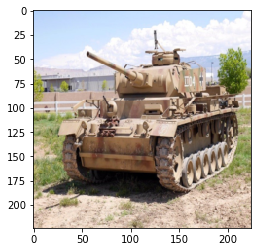

top-5 classes are:
0.997816	tank
0.001588	amphibian
0.000300	cannon
0.000082	half track
0.000081	harvester


In [33]:
img = imread('sample_images/tank.jpg')
img = imresize(img,(IMAGE_W,IMAGE_W))
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print ('top-5 classes are:')
for l in labels:
    print ('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [11]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [13]:
#I've passed this section
#extract features from images
from tqdm import tqdm
from scipy.misc import imresize
import os
X = []
Y = []

output1 = lasagne.layers.get_output(net['fc6'], input_image)

predict = theano.function([input_image], output1)

#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in tqdm(os.listdir('train/')):
    y = fname.startswith("cat")
    img = imread("train/"+fname)
    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W)))
    features = predict(img)
    Y.append(y)
    X.append(features.ravel())

  1%|▌                                                                          | 200/25000 [04:15<10:29:53,  1.52s/it]

KeyboardInterrupt: 

In [11]:
X = np.load('X_file.npy')
Y = np.load('y_file.npy')

In [12]:
X = np.asarray(X) #stack all [1xfeature] matrices into one. 
assert X.ndim==2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = Y[:len(X)]

In [13]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y)
    
    
    #print (Xtest, Xtrain, Ytest, Ytrain)
    
    
#<split data either here or by cross-validation>

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [14]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [15]:
def accuracy_score(y_true, y_predict):
    true_prediction_num = sum([int(true_value == predic_value) for true_value, predic_value in zip(y_true, y_predict)])

    return true_prediction_num / len(y_true)

In [21]:
accuracy_random_forest = []
accuracy_logistic_regression = []
accuracy_ridge = []

trials = 5
for i in range(trials):
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = 1/trials)
    random_forest_classifier = RandomForestClassifier()
    random_forest_classifier.fit(Xtrain, Ytrain)
    y_random_forest = random_forest_classifier.predict(Xtest)
    accuracy_random_forest.append(accuracy_score(Ytest, y_random_forest))

    logistic_regression_classifier = LogisticRegression()
    logistic_regression_classifier.fit(Xtrain, Ytrain)
    y_logistic_regression = logistic_regression_classifier.predict(Xtest)
    accuracy_logistic_regression.append(accuracy_score(Ytest, y_logistic_regression))

    ridge_classifier = RidgeClassifier()
    ridge_classifier.fit(Xtrain, Ytrain)
    y_ridge = ridge_classifier.predict(Xtest)
    accuracy_ridge.append(accuracy_score(Ytest, y_ridge))


print ("Random Forest Accuracy = ", sum(accuracy_random_forest)/len(accuracy_random_forest)*100, "%")
print ("Logistic Regression Accuracy = ", sum(accuracy_logistic_regression)/len(accuracy_logistic_regression)*100, "%")
print ("Ridge Classifier Accuracy = ", sum(accuracy_ridge)/len(accuracy_ridge)*100, "%")

Random Forest Accuracy =  97.456 %
Logistic Regression Accuracy =  98.416 %
Ridge Classifier Accuracy =  97.988 %


In [ ]:
print "I can do it!"

In [ ]:
Report
The main problem of this task was the need of 25k images to go through the NN(10+ hours). That was solved by the help of Shant,
who've done it and gave it by a flash drive. I think it's not illegal :)

Actually, I've done nothing special on this, only some updates, but I think that the result 97 % + is OK, isn't it?
The reason of not doing it is that we have to finish all of your 4 homeworks till wednesday

Hope you notice the comment on the top of <image loading to NN part>, which I've just passed, and next to it part is capable of loading data.
X_file and y_file are that 25k processed images taken from Shant's laptop.

Thanks,
Nairi.